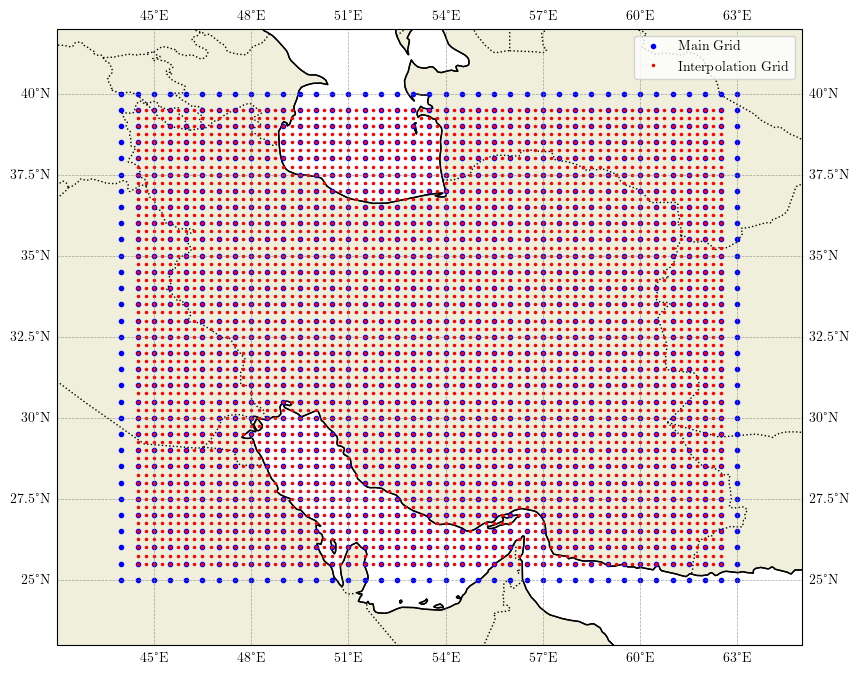

In [1]:
# Aliakbar Zarkoob, AKA "XIV"
# Gmail: XIV.Aliakbar.Zarkoob@gmail.com
# Telegram: @XIVAliakbar


import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

INTERVAL = 0.5 # unit: degrees
LAT = np.arange(25, 40+INTERVAL, INTERVAL)
LON = np.arange(44, 63+INTERVAL, INTERVAL)
LON, LAT = np.meshgrid(LON, LAT)

INTERVAL_INT = 0.25 # unit: degrees
LAT_INT = np.arange(25.5, 39.5+INTERVAL_INT, INTERVAL_INT)
LON_INT = np.arange(44.5, 62.5+INTERVAL_INT, INTERVAL_INT)
LON_INT, LAT_INT = np.meshgrid(LON_INT, LAT_INT)

extent = np.array([np.min(LON), np.max(LON), np.min(LAT), np.max(LAT)]) + 2*np.array([-1, 1, -1, 1])
fig, ax = plt.subplots(
    figsize=(10, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')

plt.plot(LON.flatten(), LAT.flatten(), marker='.', linestyle='none', color='b', label='Main Grid')
plt.plot(LON_INT.flatten(), LAT_INT.flatten(), marker='.', linestyle='none', color='r', markersize=3, label='Interpolation Grid')

gl = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True,
    linewidth=0.5, 
    color='gray', 
    alpha=0.7, 
    linestyle='--'
)

gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}
# gl.top_labels = False
# gl.right_labels = False

plt.legend()
# plt.axis('equal')

plt.show()


In [2]:
# Export Grid Points

gp = np.hstack((LON.reshape(-1, 1), LAT.reshape(-1, 1)))
np.savetxt('grid_main.txt', gp, delimiter='\t', fmt='%2f')
gp_int = np.hstack((LON_INT.reshape(-1, 1), LAT_INT.reshape(-1, 1)))
np.savetxt('grid_int.txt', gp_int, delimiter='\t', fmt='%2f')

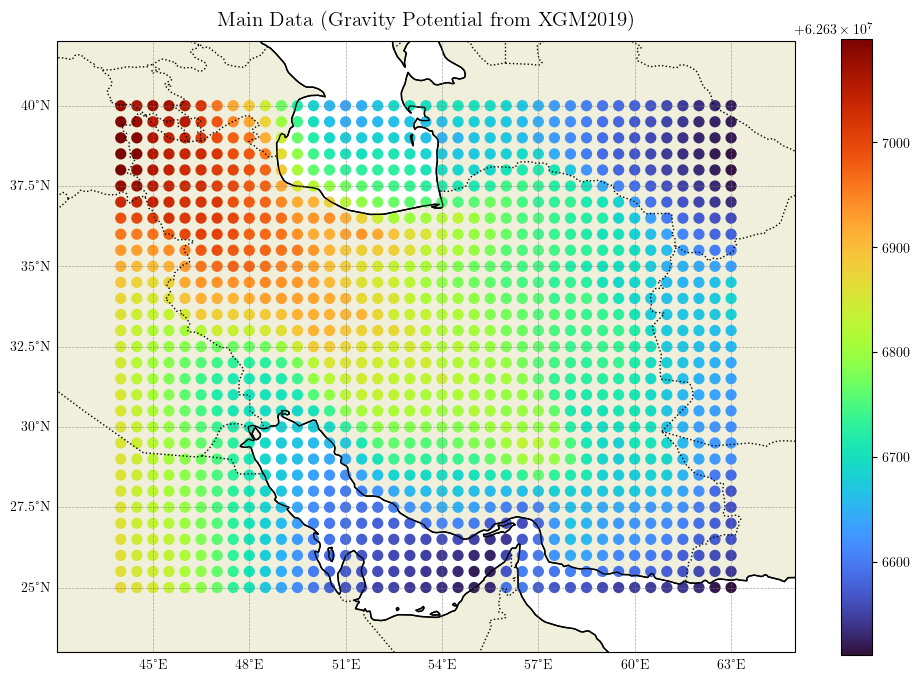

In [3]:

data = np.loadtxt('MainData.dat', skiprows=32)
data = data[:, 1:]

extent = np.array([np.min(LON), np.max(LON), np.min(LAT), np.max(LAT)]) + 2*np.array([-1, 1, -1, 1])
fig, ax = plt.subplots(
    figsize=(10, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')

sc = ax.scatter(data[:, 0], data[:, 1], 200, data[:, 3], '.', cmap='turbo', transform=ccrs.PlateCarree())
cbar = fig.colorbar(sc, ax=ax, orientation='vertical', shrink=0.8)

gl = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True,
    linewidth=0.5, 
    color='gray', 
    alpha=0.7, 
    linestyle='--'
)

gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}
gl.top_labels = False
gl.right_labels = False
# plt.axis('equal')
plt.title('Main Data (Gravity Potential from XGM2019)', fontsize=15, pad=12)
plt.tight_layout()

plt.show()

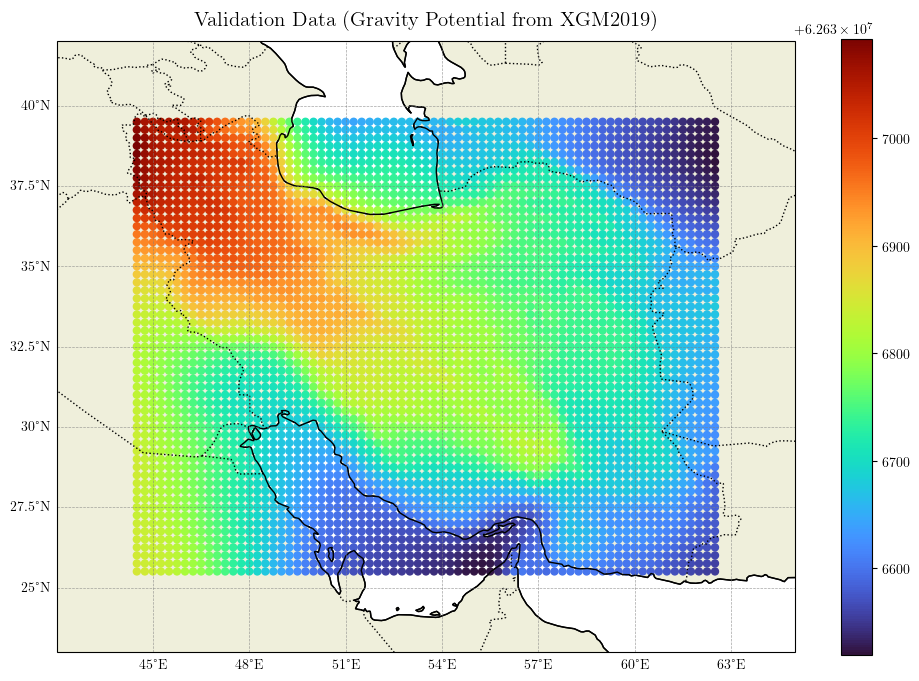

In [4]:

data_eval = np.loadtxt('ValidationData.dat', skiprows=32)
data_eval = data_eval[:, 1:]

extent = np.array([np.min(LON), np.max(LON), np.min(LAT), np.max(LAT)]) + 2*np.array([-1, 1, -1, 1])
fig, ax = plt.subplots(
    figsize=(10, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')

sc = ax.scatter(data_eval[:, 0], data_eval[:, 1], 100, data_eval[:, 3], '.', cmap='turbo', transform=ccrs.PlateCarree())
cbar = fig.colorbar(sc, ax=ax, orientation='vertical', shrink=0.8)

gl = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True,
    linewidth=0.5, 
    color='gray', 
    alpha=0.7, 
    linestyle='--'
)

gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}
gl.top_labels = False
gl.right_labels = False
# plt.axis('equal')
plt.title('Validation Data (Gravity Potential from XGM2019)', fontsize=15, pad=12)
plt.tight_layout()

plt.show()

In [5]:
from pyproj import Geod
from numpy.linalg import norm
from numpy.linalg import inv


# --- Convert Geodetic Coordinates To Radians ------------------------------------------------------------
geo_coord_data = np.deg2rad(data[:, :2])
geo_coord_data = np.hstack((geo_coord_data, data[:, 2].reshape(-1, 1)))
geo_coord_eval = np.deg2rad(data_eval[:, :2])
geo_coord_eval = np.hstack((geo_coord_eval, data_eval[:, 2].reshape(-1, 1)))
# --------------------------------------------------------------------------------------------------------

# --- Convert Geodetic Coordinates To Cartesian ----------------------------------------------------------
wgs84 = Geod(ellps="WGS84")
# N = wgs84.a**2 / np.sqrt((wgs84.a**2)*np.cos(geo_coord_data[:, 1])**2 + (wgs84.a**2)*np.sin(geo_coord_data[:, 1])**2)
N = wgs84.a / np.sqrt(1 - wgs84.es * np.sin(geo_coord_data[:, 1])**2)
X = (N + geo_coord_data[:, 2])*np.cos(geo_coord_data[:, 1])*np.cos(geo_coord_data[:, 0])
Y = (N + geo_coord_data[:, 2])*np.cos(geo_coord_data[:, 1])*np.sin(geo_coord_data[:, 0])
Z = (wgs84.b**2*N/wgs84.a**2 + geo_coord_data[:, 2])*np.sin(geo_coord_data[:, 1])
cart_coord_data = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1), Z.reshape(-1, 1)))
# N = wgs84.a**2 / np.sqrt((wgs84.a**2)*np.cos(geo_coord_eval[:, 1])**2 + (wgs84.a**2)*np.sin(geo_coord_eval[:, 1])**2)
N = wgs84.a / np.sqrt(1 - wgs84.es * np.sin(geo_coord_eval[:, 1])**2)
X = (N + geo_coord_eval[:, 2])*np.cos(geo_coord_eval[:, 1])*np.cos(geo_coord_eval[:, 0])
Y = (N + geo_coord_eval[:, 2])*np.cos(geo_coord_eval[:, 1])*np.sin(geo_coord_eval[:, 0])
Z = (wgs84.b**2*N/wgs84.a**2 + geo_coord_eval[:, 2])*np.sin(geo_coord_eval[:, 1])
cart_coord_eval = np.hstack((X.reshape(-1, 1), Y.reshape(-1, 1), Z.reshape(-1, 1)))
# --------------------------------------------------------------------------------------------------------

def AbelPoisson_Kernel(x, y, h, R):
    """
    Computes the Abel-Poisson kernel for points x and y on a sphere of radius R
    
    Parameters:
        x (ndarray): A vector representing a point on the sphere (shape: (3,))
        y (ndarray): A vector representing a point on the sphere (shape: (3,))
        h (float): Smoothing parameter for the kernel, 0 < h < 1
        R (float): Radius of the sphere
    
    Returns:
        float: The value of the Poisson kernel
    """
    
    return 0.25/np.pi * (norm(x)**2 * norm(y)**2 - h**2 * R**4)/(norm(x)**2 * norm(y)**2 + h**2 * R**4 - 2*h*R**2*np.dot(x, y))**(3/2)
    # return (R**2 - h**2) / (R**2 + h**2 - 2 * h * R * np.dot(x, y)/(norm(x)*norm(y)))**(3/2)
    # return 0.25/np.pi * (1 - h**2)/((1 + h**2 - 2*h*np.dot(x, y))**(3/2))


In [6]:
# cart_coord_data = cart_coord_data / norm(cart_coord_data, axis=1, keepdims=True)
# cart_coord_eval = cart_coord_eval / norm(cart_coord_eval, axis=1, keepdims=True)

In [7]:

# --- Create Design Matrix ------------------------------------------------------------------------------
N = len(data) # Number of Input Data
R = 6371000 # Mean Radius of Earth (meters)
A = np.zeros((N, N))
h = 0.7
for i in range(N):
    for j in range(N):
        A[i, j] = AbelPoisson_Kernel(cart_coord_data[i, :], cart_coord_data[j, :], h, R)
# -------------------------------------------------------------------------------------------------------

# --- Create Design Matrix For Interpolation ------------------------------------------------------------
U = len(data_eval)
A_int = np.zeros((U, N))

for i in range(U):
    for j in range(N):
        A_int[i, j] = AbelPoisson_Kernel(cart_coord_eval[i, :], cart_coord_data[j, :], h, R)
# -------------------------------------------------------------------------------------------------------

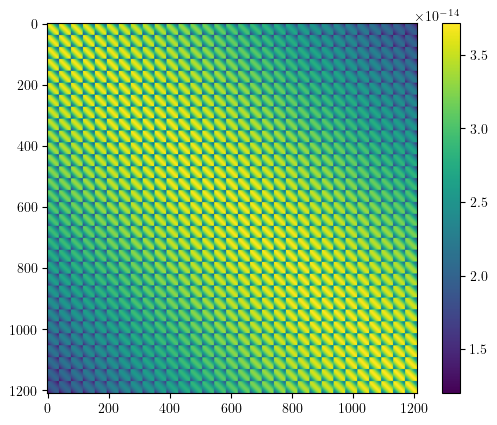

Condition Number of "A": 2.5808671365914915e+19
Condition Number of "A.T@A": 2.0747540950945428e+20
Condition Number of "A.T@A + LAMBDA*np.eye(N)":  129271124475978.83
LAMBDA = 1e-35


In [8]:
import matplotlib.pyplot as plt

plt.imshow(A)
plt.colorbar()
plt.show()
LAMBDA = 0.00000000000000000000000000000000001

print(f'Condition Number of "A": {np.linalg.cond(A)}')
print(f'Condition Number of "A.T@A": {np.linalg.cond(A.T@A)}')
print(f'Condition Number of "A.T@A + LAMBDA*np.eye(N)":  {np.linalg.cond(A.T@A + LAMBDA*np.eye(N))}\nLAMBDA = {LAMBDA}')

In [16]:

# --- Compute Coefficients ------------------------------------------------------------------------------
l = data[:, 3].reshape(-1, 1)
# coeff = inv(A.T@A + LAMBDA*np.eye(N))@A.T@l
coeff = inv(A)@l
# -------------------------------------------------------------------------------------------------------

# --- Interpolation -------------------------------------------------------------------------------------        
int = A_int@coeff
diff = data_eval[:, 3].reshape(-1, 1) - int
# -------------------------------------------------------------------------------------------------------


In [17]:
import numpy as np
from scipy.linalg import cho_factor, cho_solve


cov_matrix = np.eye(len(l))
c, lower = cho_factor(cov_matrix)
coeff = cho_solve((c, lower), A.T @ l)

int = A_int@coeff
diff = data_eval[:, 3].reshape(-1, 1) - int

In [10]:
import numpy as np
from scipy.io import savemat


test = {
    'A': A,
    'l': l,
    'A_int': A_int,
    'data_eval': data_eval,
}
savemat('test.mat', test)

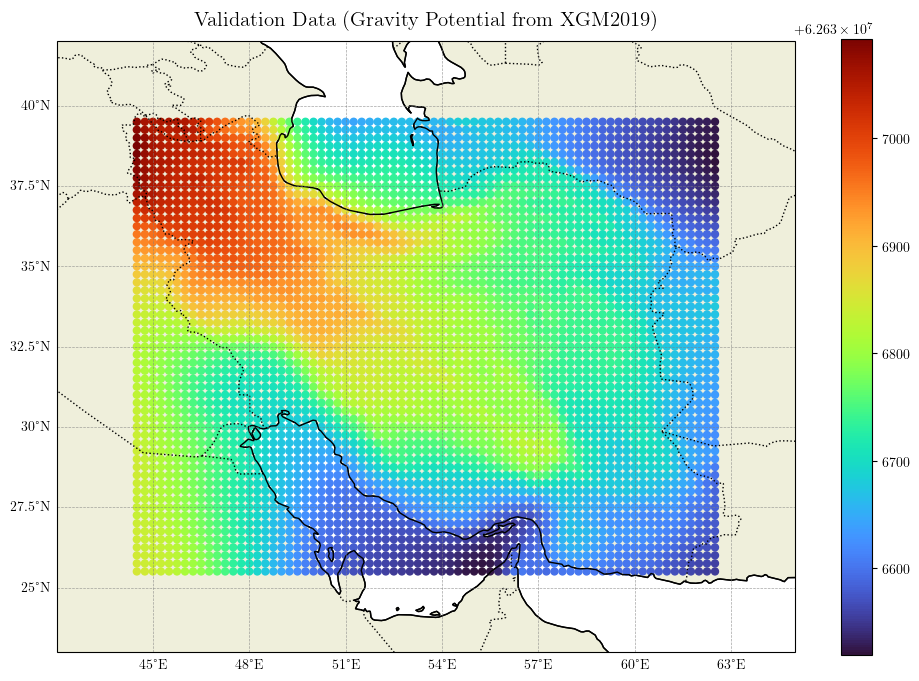

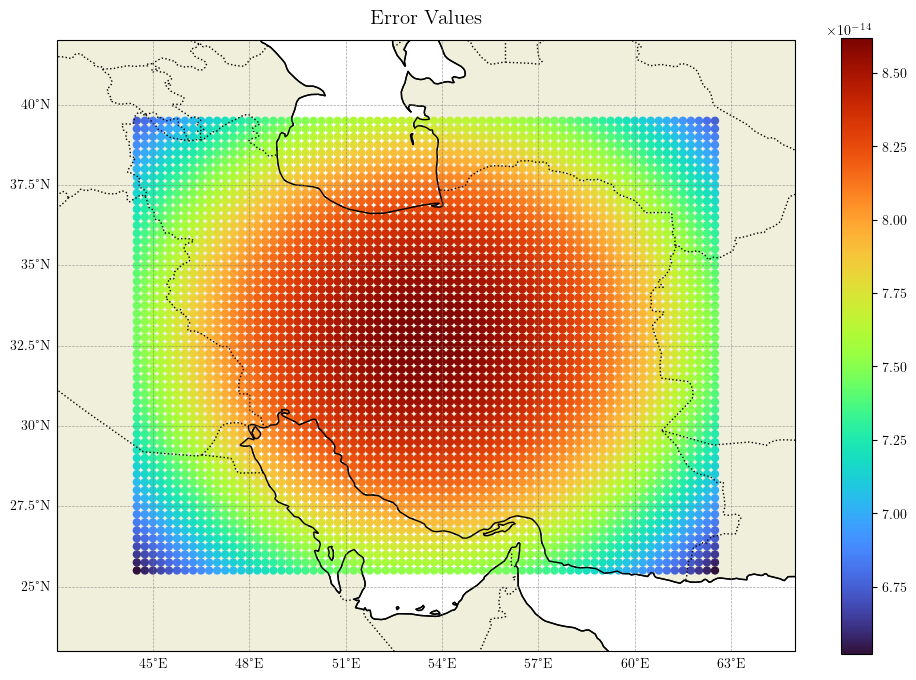

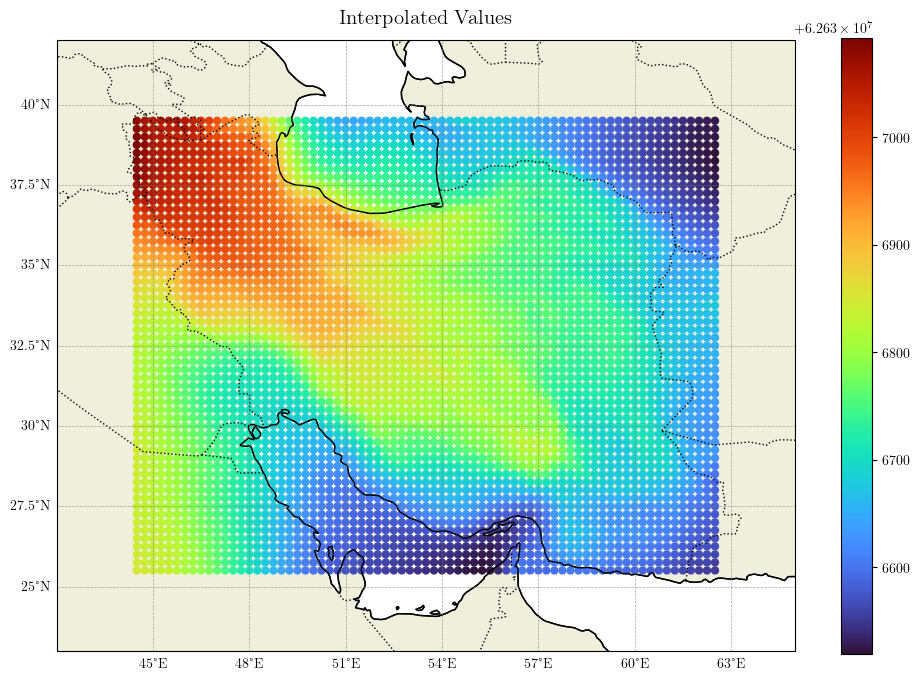

In [15]:

extent = np.array([np.min(LON), np.max(LON), np.min(LAT), np.max(LAT)]) + 2*np.array([-1, 1, -1, 1])
fig, ax = plt.subplots(
    figsize=(10, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')

sc = ax.scatter(data_eval[:, 0], data_eval[:, 1], 100, data_eval[:, 3], '.', cmap='turbo', transform=ccrs.PlateCarree())
cbar = fig.colorbar(sc, ax=ax, orientation='vertical', shrink=0.8)

gl = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True,
    linewidth=0.5, 
    color='gray', 
    alpha=0.7, 
    linestyle='--'
)

gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}
gl.top_labels = False
gl.right_labels = False
# plt.axis('equal')
plt.title('Validation Data (Gravity Potential from XGM2019)', fontsize=15, pad=12)
plt.tight_layout()

plt.show()


fig, ax = plt.subplots(
    figsize=(10, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')

sc = ax.scatter(data_eval[:, 0], data_eval[:, 1], 100, int, '.', cmap='turbo', transform=ccrs.PlateCarree())
cbar = fig.colorbar(sc, ax=ax, orientation='vertical', shrink=0.8)

gl = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True,
    linewidth=0.5, 
    color='gray', 
    alpha=0.7, 
    linestyle='--'
)

gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}
gl.top_labels = False
gl.right_labels = False
# plt.axis('equal')
plt.title('Error Values', fontsize=15, pad=12)
plt.tight_layout()

plt.show()


fig, ax = plt.subplots(
    figsize=(10, 8),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
ax.set_extent(extent, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black')

sc = ax.scatter(data_eval[:, 0], data_eval[:, 1], 100, diff, '.', cmap='turbo', transform=ccrs.PlateCarree())
cbar = fig.colorbar(sc, ax=ax, orientation='vertical', shrink=0.8)

gl = ax.gridlines(
    crs=ccrs.PlateCarree(), 
    draw_labels=True,
    linewidth=0.5, 
    color='gray', 
    alpha=0.7, 
    linestyle='--'
)

gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}
gl.top_labels = False
gl.right_labels = False
# plt.axis('equal')
plt.title('Interpolated Values', fontsize=15, pad=12)
plt.tight_layout()

plt.show()